based on https://stackoverflow.com/questions/59381695/lstm-in-pytorch-how-to-add-change-sequence-length-dimension
and https://www.tradientblog.com/2019/11/lessons-learned-building-an-ml-trading-system-that-turned-5k-into-200k/

In [1]:
from fastai.tabular import *
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
%matplotlib notebook
import matplotlib.pyplot as plt

# Data preparation

## Get the data

In [2]:
class CryptoDataset:
    """Face Landmarks dataset."""
    CLOSING_PRICE = 'close'
    PREV_CLOSING_PRICE = 'prev_close'
    DATE_COLUMN_NAME = 'date'
    ELAPSED = 'Elapsed'
    DROP_COLUMNS =['Second', 'Minute', 'Month', 'Year', \
                   'Is_quarter_end', 'Is_quarter_start', \
                   'Is_year_end', 'Is_year_start',
                   'Is_month_end', 'Is_month_start',
                   'Week', 'Dayofyear', ELAPSED]
    TARGET_FUTURE_MAX = 'target_future_max'
    TARGET_FUTURE_MIN = 'target_future_min'
    TARGET_CLOSE_ = 'target_close_future_'
    

    def __init__(self, csv_file="BTC-ETH-filtered_with_indicators.csv", predict_delta=1, sequence_size=10, batch_size=8):
        """
        Args:
            csv_file (string): Path to the csv file with the crypto stats table.
        """
        from datetime import datetime
        self.sequence_size = sequence_size
        self.df = pd.read_csv("BTC-ETH-filtered_with_indicators.csv",
                              #read dates as dates
                              parse_dates=[self.DATE_COLUMN_NAME],
                              date_parser=lambda x: datetime.fromtimestamp(int(x)),
                             )
        add_datepart(self.df, self.DATE_COLUMN_NAME, time=True);
#         self.df.index = pd.to_datetime(self.df.index)
        self.df = self.df.drop(columns=self.DROP_COLUMNS)
        
        # building the target
        self.df[[self.TARGET_CLOSE_]] = np.log(self.df[[self.CLOSING_PRICE]].shift(-predict_delta)) - np.log(self.df[[self.CLOSING_PRICE]])
        TARGETs_NAMEs.append(self.TARGET_CLOSE_)
        self.df = self.df[:-1]
        
        trvate_split = tuple(int(x * len(self.df)) for x in (0.75, 0.9, 1.0))
        tmp_train_limit = trvate_split[0]- trvate_split[0]%sequence_size
        self.train_df = self.df[:tmp_train_limit]
        tmp_valid_limit = trvate_split[1] - trvate_split[0]%sequence_size -(trvate_split[1]-trvate_split[0])%sequence_size
        self.valid_df = self.df[tmp_train_limit:tmp_valid_limit]
        self.test_df = self.df[tmp_valid_limit:(len(self.df)- len(self.df)%sequence_size)]
        del tmp_train_limit, tmp_valid_limit
        
        def __transform_df(df_to_transform, transformer, columns):
            return pd.DataFrame(transformer.transform(df_to_transform), columns=columns)
        
        preprocessing_pipeline = Pipeline([("poli-feature", PolynomialFeatures(degree=2)),
                                           ("normalizer", StandardScaler())
                                          ]).fit(self.train_df.input_data(), self.train_df.target())
        columns = preprocessing_pipeline["poli-feature"].get_feature_names(self.train_df.input_data().columns)
#         preprocessing_pipeline = StandardScaler().fit(self.train_df.input_data())
#         columns = self.train_df.input_data().columns
        self.train_data = __transform_df(self.train_df.input_data(), preprocessing_pipeline, columns=columns)
        self.valid_data = __transform_df(self.valid_df.input_data(), preprocessing_pipeline, columns=columns)
        self.test_data = __transform_df(self.test_df.input_data(), preprocessing_pipeline, columns=columns)
        
        self.labeling_pipeline = StandardScaler().fit(self.train_df.target())
        label_columns = self.train_df.target().columns
        self.train_target = __transform_df(self.train_df.target(), self.labeling_pipeline, columns=label_columns)
        self.valid_target = __transform_df(self.valid_df.target(), self.labeling_pipeline, columns=label_columns)
        self.test_target = __transform_df(self.test_df.target(), self.labeling_pipeline, columns=label_columns)
        
        self.train_data.drop(columns=['1'], inplace=True)
        self.valid_data.drop(columns=['1'], inplace=True)
        self.test_data.drop(columns=['1'], inplace=True)
        
        #clip to 90% (quantile)
        df = self.train_target.iloc[:,0]
        no_outliers_mask = df.between(df.quantile(.05), df.quantile(.95))
        minimum_not_out = np.min(df[no_outliers_mask])
        maximum_not_out = np.max(df[no_outliers_mask])
        self.train_target = self.train_target.clip(lower=minimum_not_out, upper=maximum_not_out)
        self.valid_target = self.valid_target.clip(lower=minimum_not_out, upper=maximum_not_out)
        self.test_target = self.test_target.clip(lower=minimum_not_out, upper=maximum_not_out)
        
        def create_inout_sequences(input_data: pd.DataFrame, labels: pd.DataFrame, seq_len: int):
            out_labels = torch.tensor(labels.iloc[seq_len-1:].values.astype(np.float32))
            print(input_data.shape)
            out_sequences = np.stack([input_data.iloc[i:i+seq_len] for i in range(len(input_data)-seq_len+1)])
            out_data = torch.tensor(out_sequences.reshape(-1, seq_len, input_data.shape[-1]).astype(np.float32))
            print(input_data.shape, out_data.shape, out_labels.shape)
            return out_data, out_labels
        
#         train_x_y
        self.train_loader = DataLoader(dataset=TensorDataset(*create_inout_sequences(input_data=self.train_data,
                                                                                    labels=self.train_target,
                                                                                    seq_len=sequence_size)),
                                       batch_size=batch_size, shuffle = True)
        self.val_loader = DataLoader(dataset=TensorDataset(*create_inout_sequences(input_data=self.valid_data,
                                                                                    labels=self.valid_target,
                                                                                    seq_len=sequence_size)),
                                       batch_size=batch_size)
        self.test_loader = DataLoader(dataset=TensorDataset(*create_inout_sequences(input_data=self.test_data,
                                                                                    labels=self.test_target,
                                                                                    seq_len=sequence_size)),
                                       batch_size=batch_size)

In [3]:
# def input_data(self: pd.DataFrame):
#     return self.drop(columns=[CryptoDataset.Target_closing_price_column_name])
# def target(self: pd.DataFrame):
#     return self[[CryptoDataset.Target_closing_price_column_name]]

# pd.DataFrame.input_data = input_data
# pd.DataFrame.target = target

# Study

In [4]:
# from IPython.display import display
# pd.set_option('display.max_columns', 500)
# np.set_printoptions(threshold=sys.maxsize)
# from sklearn.ensemble import RandomForestRegressor
# rf = RandomForestRegressor(n_estimators=100, criterion='mae')
# rf.fit(dataset.train_df.input_data(), dataset.train_df.target())
# print(rf.feature_importances_)
# all_features = dataset.train_df.input_data().columns
# print("all columns\n", *[str(a) +'\n ' for a in zip(all_features, rf.feature_importances_)])
# plot_params = 'parameters'
# plot_importances = 'importances'
# df = pd.DataFrame({plot_params:all_features[rf.feature_importances_ > 0.].tolist(),
#                    plot_importances:rf.feature_importances_[rf.feature_importances_ > 0.]})
# ax = df.plot.bar(x=plot_params, y=plot_importances, rot=0)

### dataset build

In [5]:
def input_data(self: pd.DataFrame):
    return self.drop(columns=['fake', 'volume_em', *TARGETs_NAMEs])
#     return self[['open', 'high', 'low', 'close', 'volume', 'others_cr',
#                  'momentum_kama', 'trend_ichimoku_b', 'trend_mass_index',
#                  'trend_ema_slow', 'trend_ema_fast', 'volatility_bbm']]

pd.DataFrame.input_data = input_data


def target(self: pd.DataFrame):
    return self[TARGETs_NAMEs]

pd.DataFrame.target = target

In [6]:
BATCH_SIZE = 32
SEQUENCE_SIZE = 24
TARGETs_NAMEs = []
dataset=CryptoDataset(predict_delta=1,
                      batch_size=BATCH_SIZE,
                      sequence_size=SEQUENCE_SIZE)

(1032, 1829)
(1032, 1829) torch.Size([1009, 24, 1829]) torch.Size([1009, 1])
(192, 1829)
(192, 1829) torch.Size([169, 24, 1829]) torch.Size([169, 1])
(168, 1829)
(168, 1829) torch.Size([145, 24, 1829]) torch.Size([145, 1])


# Train

In [7]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
DEVICE

device(type='cuda')

## Model

In [8]:
class SentimentNet(nn.Module):
    def __init__(self, features, output_size=1,
                 sequence_size=10,
                 n_layers=1,
                 drop_prob=0.5, device=torch.device("cpu")):
        super(SentimentNet, self).__init__()
        
        embedding_dim=features*2
        hidden_dim=features
        
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.device = device
        
        self.liniar = nn.Linear(features, embedding_dim)
#         self.normalization_pre_lstm = nn.LayerNorm([sequence_size, embedding_dim])
        self.normalization_pre_lstm = nn.BatchNorm1d(num_features=sequence_size) # embedding_dim)
        
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_dim,
                            num_layers=n_layers, dropout=drop_prob, batch_first=True)
#         self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Sequential(nn.Linear(hidden_dim, hidden_dim//2),
                                nn.BatchNorm1d(num_features=hidden_dim//2),# if reenabling, search for "No need to skip this since have dropped the bn"
#                                 nn.LayerNorm([hidden_dim//2]),
                                nn.LeakyReLU(),
                                nn.Dropout(drop_prob),
                                nn.Linear(hidden_dim//2, output_size))
        
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).requires_grad_().to(self.device)
        # Initialize cell state
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).requires_grad_().to(self.device)
        
        out = self.liniar(x)
        out = self.normalization_pre_lstm(out)
        out = torch.tanh(out)
        out, (hn, cn) = self.lstm(out, (h0, c0))
        out = torch.add(out, x)
        # Index hidden state of last time step
        out = self.fc(out[:, -1, :])
        
        return out

In [9]:
# class CustomLoss(nn.L1Loss):
#     def __init__(self, size_average=None, reduce=None, reduction='mean'):
#         super(CustomLoss, self).__init__(size_average, reduce, reduction)

#     def forward(self, input, target):
# #         b = input.expand(-1,target.shape[1])
# #         return torch.exp(F.l1_loss(b, target[:,0], reduction=self.reduction))
#         return torch.exp(torch.max(torch.abs(input - target[:,0])))
        

In [10]:
features_count = dataset.train_data.shape[1]
# output_count = len(dataset.train_df.target().columns)
# output_size = 1
# embedding_dim = 400
# hidden_dim = 512
# n_layers = 2

output_count = 1

model = SentimentNet(features_count, output_size=output_count,
                     device=DEVICE, n_layers=4, sequence_size=SEQUENCE_SIZE, drop_prob=0.4)
model.to(DEVICE)

SentimentNet(
  (liniar): Linear(in_features=1829, out_features=3658, bias=True)
  (normalization_pre_lstm): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(3658, 1829, num_layers=4, batch_first=True, dropout=0.4)
  (fc): Sequential(
    (0): Linear(in_features=1829, out_features=914, bias=True)
    (1): BatchNorm1d(914, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=914, out_features=1, bias=True)
  )
)

In [11]:
lr=0.0003
# criterion = CustomLoss()
criterion = nn.L1Loss()
# binary_criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

epochs = 300
counter = 0
print_every = 5
clip = 5
valid_loss_min = np.Inf
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr,
                                                   steps_per_epoch=len(dataset.train_loader),
                                                   epochs=epochs)

In [12]:
%matplotlib notebook
import matplotlib.pyplot as plt
train_losses, valid_losses = [], []

<IPython.core.display.Javascript object>


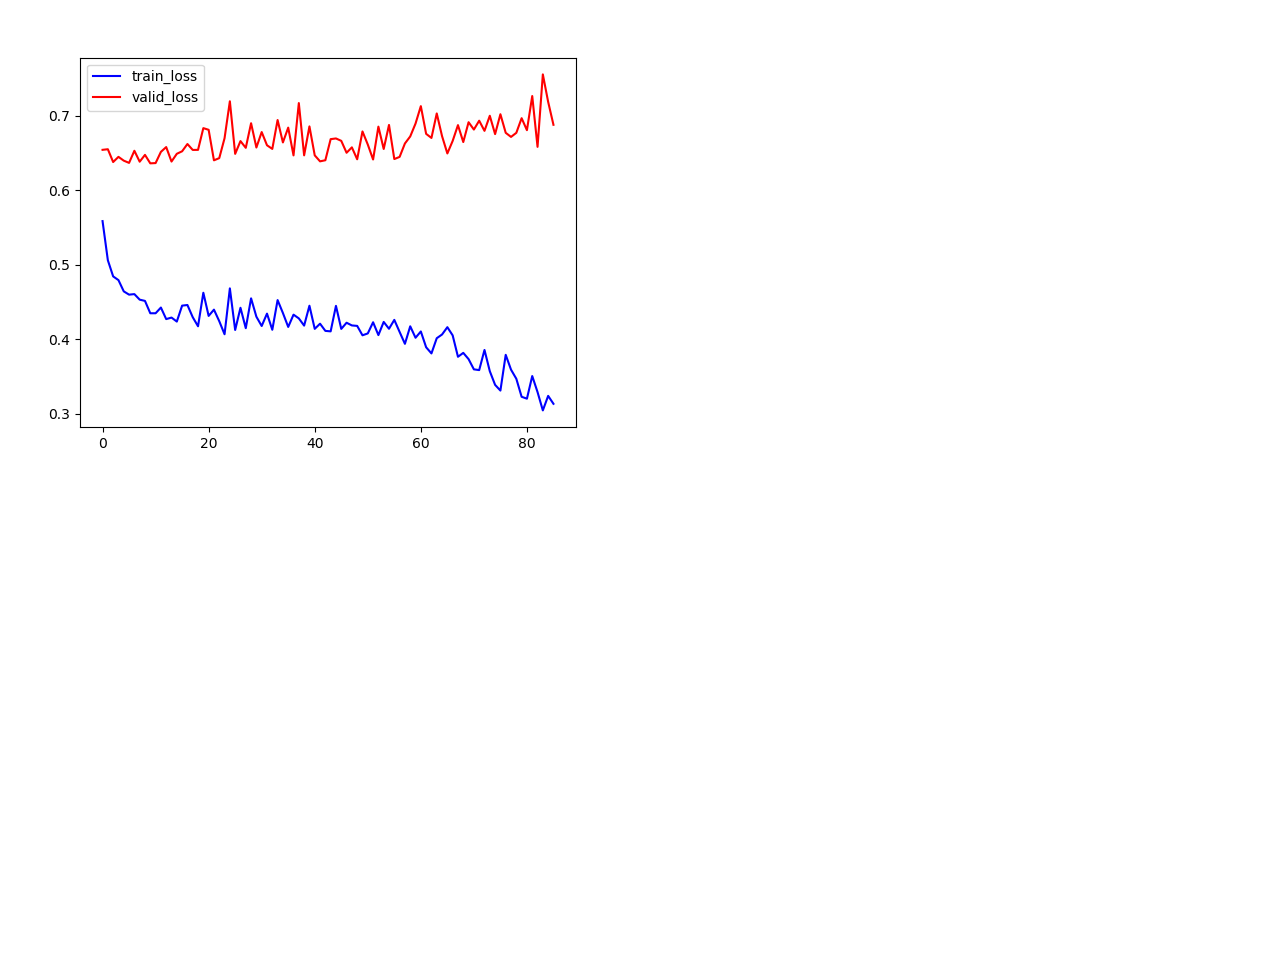

Epoch: 0... Loss: 0.558366... Val Loss: 0.653987
Validation loss decreased (inf --> 0.653987).  Saving model ...
Epoch: 1... Loss: 0.505856... Val Loss: 0.654796
Epoch: 2... Loss: 0.484181... Val Loss: 0.637614
Validation loss decreased (0.653987 --> 0.637614).  Saving model ...
Epoch: 3... Loss: 0.479185... Val Loss: 0.644571
Epoch: 4... Loss: 0.464089... Val Loss: 0.639476
Epoch: 5... Loss: 0.459692... Val Loss: 0.636474
Validation loss decreased (0.637614 --> 0.636474).  Saving model ...
Epoch: 6... Loss: 0.460420... Val Loss: 0.652732
Epoch: 7... Loss: 0.452987... Val Loss: 0.638067
Epoch: 8... Loss: 0.451307... Val Loss: 0.647211
Epoch: 9... Loss: 0.434724... Val Loss: 0.635867
Validation loss decreased (0.636474 --> 0.635867).  Saving model ...
Epoch: 10... Loss: 0.434719... Val Loss: 0.636220
Epoch: 11... Loss: 0.442386... Val Loss: 0.651266
Epoch: 12... Loss: 0.426889... Val Loss: 0.657686
Epoch: 13... Loss: 0.428953... Val Loss: 0.638257
Epoch: 14... Loss: 0.423561... Val Loss

KeyboardInterrupt: 

In [13]:
fig, ax = plt.subplots(1,1)
ax.set_xlabel('epochs')
ax.set_ylabel('losses')

def train():
    model.train()

    for train, train_target in dataset.train_loader:
        if train.shape[0] < 2:# No need to skip this since have dropped the bn
            continue
            
        # Load data as a torch tensor with gradient accumulation abilities
        train = train.requires_grad_().to(DEVICE)
        train_target = train_target.to(DEVICE)
#         print(train.shape)
#         print(train_target.shape)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        # Forward pass to get output/logits
        outputs = model(train)
#         print(outputs.shape, train_target.shape)
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, train_target)

        # Getting gradients w.r.t. parameters
        loss.backward()
        # Updating parameters
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        lr_scheduler.step()

def eval_and_save(on_epoch=0):
    model.eval()
    global valid_loss_min
    
    #evaluate first the full train set
    epoch_train_losses = []
    for train, train_target in dataset.train_loader:
        # Forward pass to get output/logits
        train = train.to(DEVICE)
        train_target = train_target.to(DEVICE)
        outputs = model(train)
        train_loss = criterion(outputs, train_target)
        epoch_train_losses.append(train_loss.item())
    avg_epoch_train_loss = np.mean(epoch_train_losses)
    train_losses.append(avg_epoch_train_loss)
   
        
    #eval the valid set
    epoch_val_losses = []
    for val_in, val_out in dataset.val_loader:
        # Forward pass to get output/logits
        val_in = val_in.to(DEVICE)
        val_out = val_out.to(DEVICE)
        outputs = model(val_in)
        val_loss = criterion(outputs, val_out)
        epoch_val_losses.append(val_loss.item())
    avg_epoch_val_loss = np.mean(epoch_val_losses)
    valid_losses.append(avg_epoch_val_loss)
    
    
    print("Epoch: {}...".format(epoch),
          "Loss: {:.6f}...".format(avg_epoch_train_loss),
          "Val Loss: {:.6f}".format(avg_epoch_val_loss))
    if avg_epoch_val_loss < valid_loss_min:
        torch.save(model.state_dict(), './state_dict15c5.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,avg_epoch_val_loss))
        valid_loss_min = avg_epoch_val_loss
            

    plt.cla()
    ax.plot(train_losses, 'b', label='train_loss')
    ax.plot(valid_losses, 'r', label='valid_loss')
    ax.legend()
    fig.canvas.draw()
            
        
for epoch in range(epochs):
    train()
    eval_and_save(epoch)
        

# Test

## Visualize

In [14]:
import matplotlib.pyplot as plt

class Visualizer:
    colors=['blue','black', 'red']
    
    def __init__(self):
        self.date_pred_targ_dict: dict = dict()
        
    def add(self, timestamp, pred, targ, color='red'):
        pred_len = pred.shape[1]
        targ_len = targ.shape[1]
        self.date_pred_targ_dict[color] = pd.concat([self.date_pred_targ_dict.get(color, pd.DataFrame()),
                                                     pd.concat([pd.DataFrame(timestamp),
                                                       pd.DataFrame(pred, columns=[f'predicted{i}' for i in range(pred_len)]),
                                                       pd.DataFrame(targ, columns=[f'target{i}' for i in range(targ_len)])],
                                                    axis=1)])
    
    def plot(self):
        for color in self.colors:
            color_df = visualizer.date_pred_targ_dict.get(color, pd.DataFrame())
            plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
            plt.plot(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
            plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
            plt.plot(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
        plt.show()

## Eval

In [15]:
# Loading the best model
model.load_state_dict(torch.load('./state_dict15c5.pt'))
visualizer = Visualizer()

mse_losses = []
mae_losses = []
kldiv_losses = []
totalIndexes = 0
custom_batch = BATCH_SIZE
# index_of_elapsed = dataset.train_data.columns.tolist().index(dataset.ELAPSED)

model.eval()

# #TRAIN
# for inputs, labels in tqdm(dataset.train_loader):
#     if inputs.shape[0] != custom_batch:
#         continue
#       totalIndexes += 1
#     inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
#     output, h = model(inputs, h)
#     visualizer.add(np.arange(len(inputs)), output, labels[:,-1], color='black')
    
#VALIDATE       
for val_in, val_out in dataset.val_loader:
    # Forward pass to get output/logits
    val_in = val_in.to(DEVICE)
    val_out = val_out.to(DEVICE)
    outputs = model(val_in)
#     val_loss = criterion(outputs, val_out)
#     val_losses.append(val_loss.item())

    visualizer.add(np.arange(len(val_out))+totalIndexes, np.array(outputs), np.array(val_out[:,0].view(-1,1)), color='blue')
    totalIndexes += len(val_out)
    
#TEST
for test_in, test_out in dataset.test_loader:
    # Forward pass to get output/logits
    test_in = test_in.to(DEVICE)
    test_out = test_out.to(DEVICE)
    outputs = model(test_in)
#     val_loss = criterion(outputs, val_out)
#     val_losses.append(val_loss.item())

    visualizer.add(np.arange(len(test_out))+totalIndexes, np.array(outputs), np.array(test_out[:,0].view(-1,1)))
    totalIndexes += len(test_out)
    
    mse_losses.append(nn.MSELoss()(outputs, test_out[:,0].view(-1,1)).item())
    mae_losses.append(nn.L1Loss()(outputs, test_out[:,0].view(-1,1)).item())
    kldiv_losses.append(nn.KLDivLoss()(outputs, test_out[:,0].view(-1,1)).item())
    

print("MSE loss: {:.8f}".format(np.mean(mse_losses)))
print("MAE loss: {:.8f}".format(np.mean(mae_losses)))
print("KLDiv loss: {:.8f}".format(np.mean(kldiv_losses)))

C:\Users\octav\Miniconda3\envs\tf_gpu\lib\site-packages\torch\nn\functional.py:1946: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


MSE loss: 0.42487826
MAE loss: 0.52023978
KLDiv loss: -0.11454240


# Visualize plot

In [17]:
predictedMax = 'predicted0'
# predictedMin = 'predicted1'
targetMax = 'target0'
# targetMin = 'target1'
plot_variation_scale=100

## valid

<IPython.core.display.Javascript object>


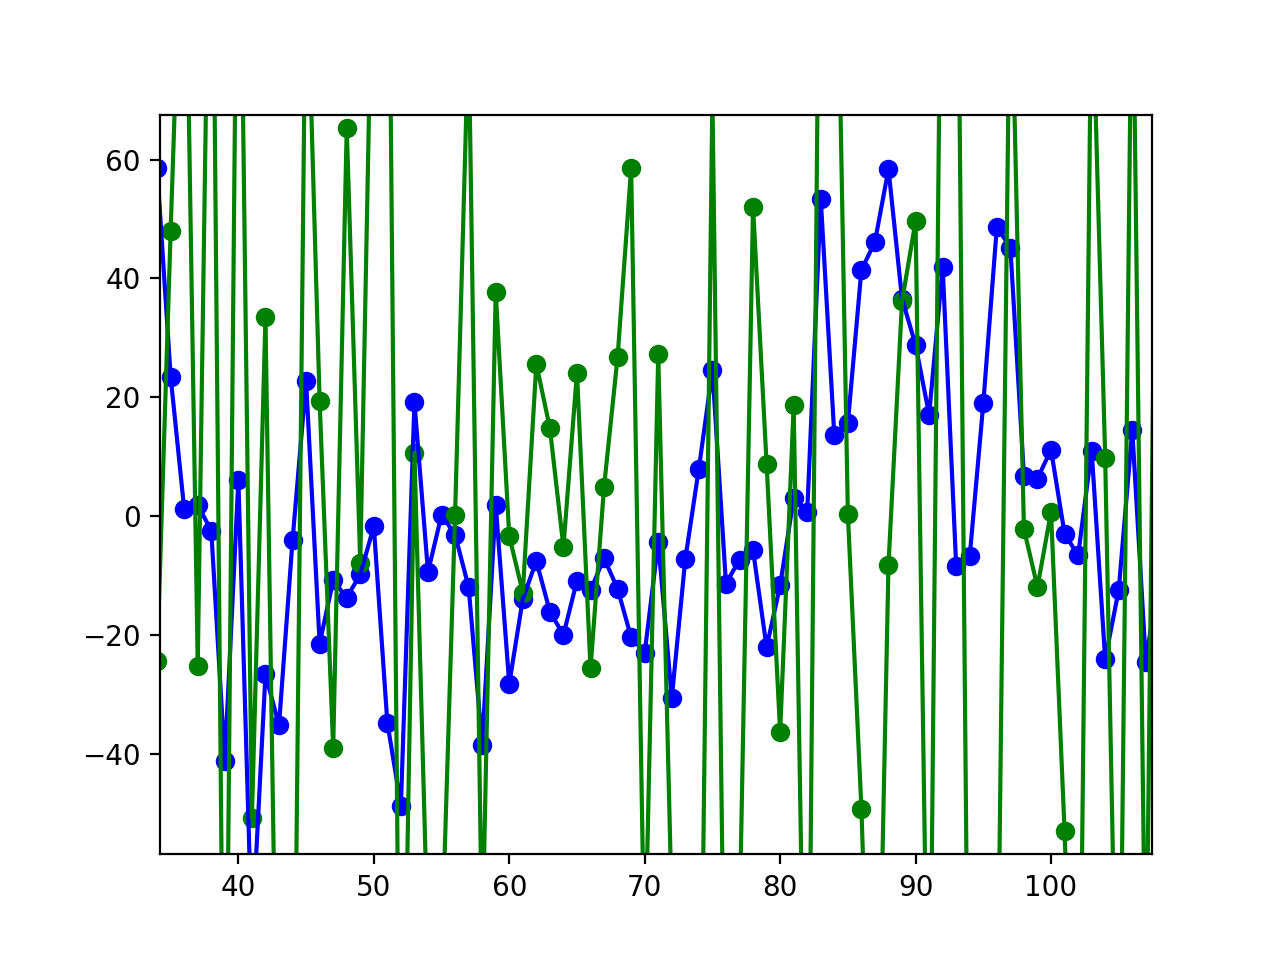

In [18]:
fig, ax = plt.subplots(1)

color_df = visualizer.date_pred_targ_dict.get('blue', pd.DataFrame())

ax0 = ax
# ax1 = ax[1]

ax0.scatter(color_df.iloc[:,0], color_df[[predictedMax]]*plot_variation_scale, color='b')
ax0.plot(color_df.iloc[:,0], color_df[[predictedMax]]*plot_variation_scale, color='b')
ax0.scatter(color_df.iloc[:,0], color_df[[targetMax]]*plot_variation_scale, color='g')
ax0.plot(color_df.iloc[:,0], color_df[[targetMax]]*plot_variation_scale, color='g')

# ax1.scatter(color_df.iloc[:,0], color_df[[predictedMin]]*plot_variation_scale, color='m')
# ax1.plot(color_df.iloc[:,0], color_df[[predictedMin]]*plot_variation_scale, color='m')
# ax1.scatter(color_df.iloc[:,0], color_df[[targetMin]]*plot_variation_scale, color='r')
# ax1.plot(color_df.iloc[:,0], color_df[[targetMin]]*plot_variation_scale, color='r')

fig.show()

# test

<IPython.core.display.Javascript object>


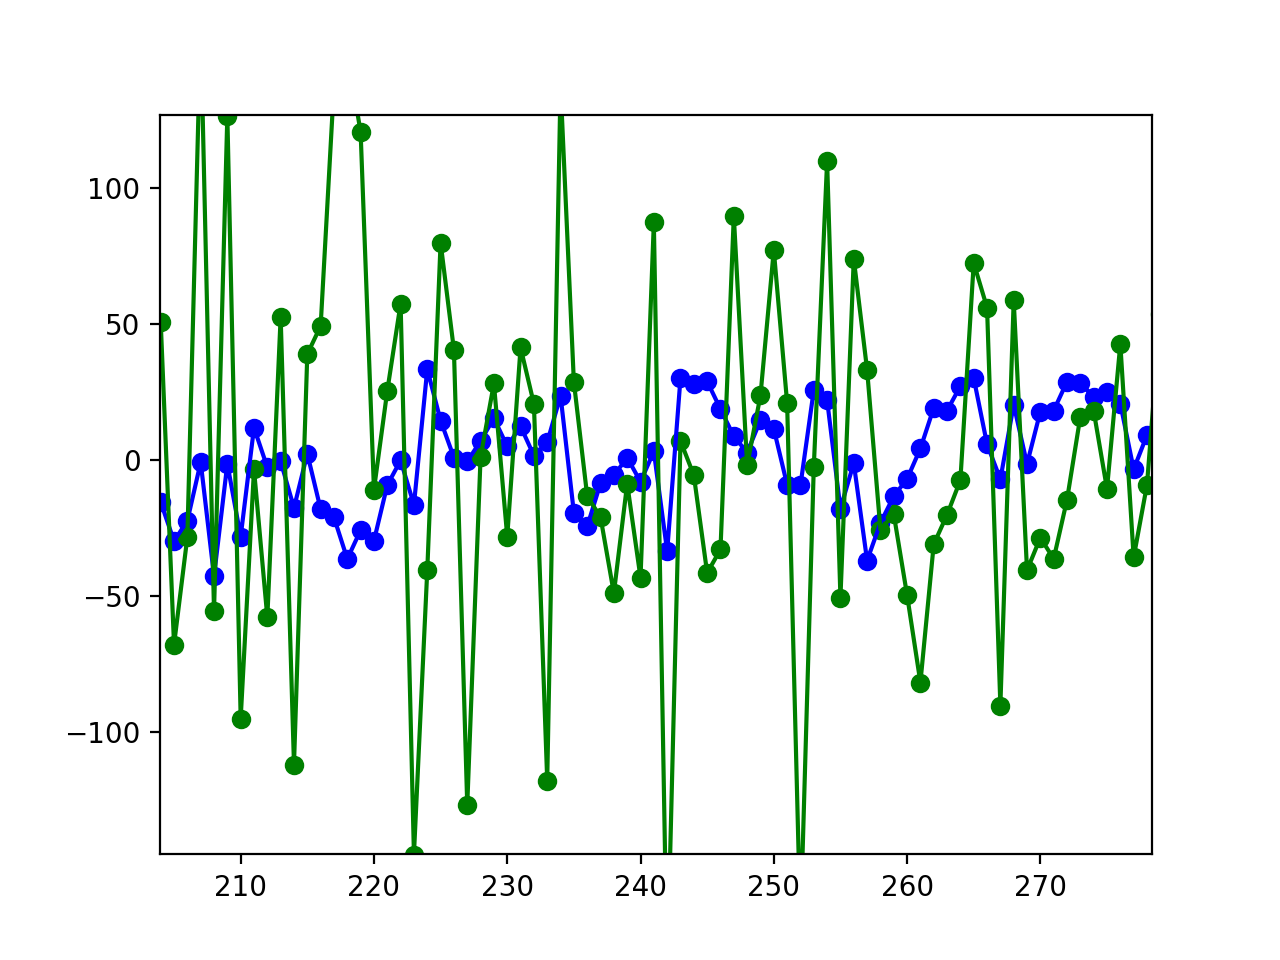

In [18]:
fig, ax = plt.subplots(1)

color_df = visualizer.date_pred_targ_dict.get('red', pd.DataFrame())

ax0 = ax

ax0.scatter(color_df.iloc[:,0], color_df[[predictedMax]]*plot_variation_scale, color='b')
ax0.plot(color_df.iloc[:,0], color_df[[predictedMax]]*plot_variation_scale, color='b')
ax0.scatter(color_df.iloc[:,0], color_df[[targetMax]]*plot_variation_scale, color='g')
ax0.plot(color_df.iloc[:,0], color_df[[targetMax]]*plot_variation_scale, color='g')

fig.show()

# preview

In [29]:
color_df.head()

,0,predicted0,target0
0,169,-0.038828,-2.454220
1,170,0.231536,-0.096489
2,171,-0.237111,-0.797044
3,172,0.026808,-1.043665
4,173,0.122054,0.074567


In [31]:
dataset.labeling_pipeline.inverse_transform(color_df[[predictedMax]])

array([[-1.710341e-04],
       [ 9.459078e-04],
       [-9.901943e-04],
       [ 1.001243e-04],
       ...,
       [ 3.347622e-05],
       [ 4.242688e-04],
       [ 1.386056e-03],
       [-1.478772e-04]], dtype=float32)

In [32]:
dataset.labeling_pipeline.inverse_transform(color_df[[targetMax]])

array([[-0.01015 ],
       [-0.000409],
       [-0.003303],
       [-0.004322],
       ...,
       [-0.000902],
       [-0.001701],
       [ 0.002913],
       [ 0.002963]], dtype=float32)

<IPython.core.display.Javascript object>


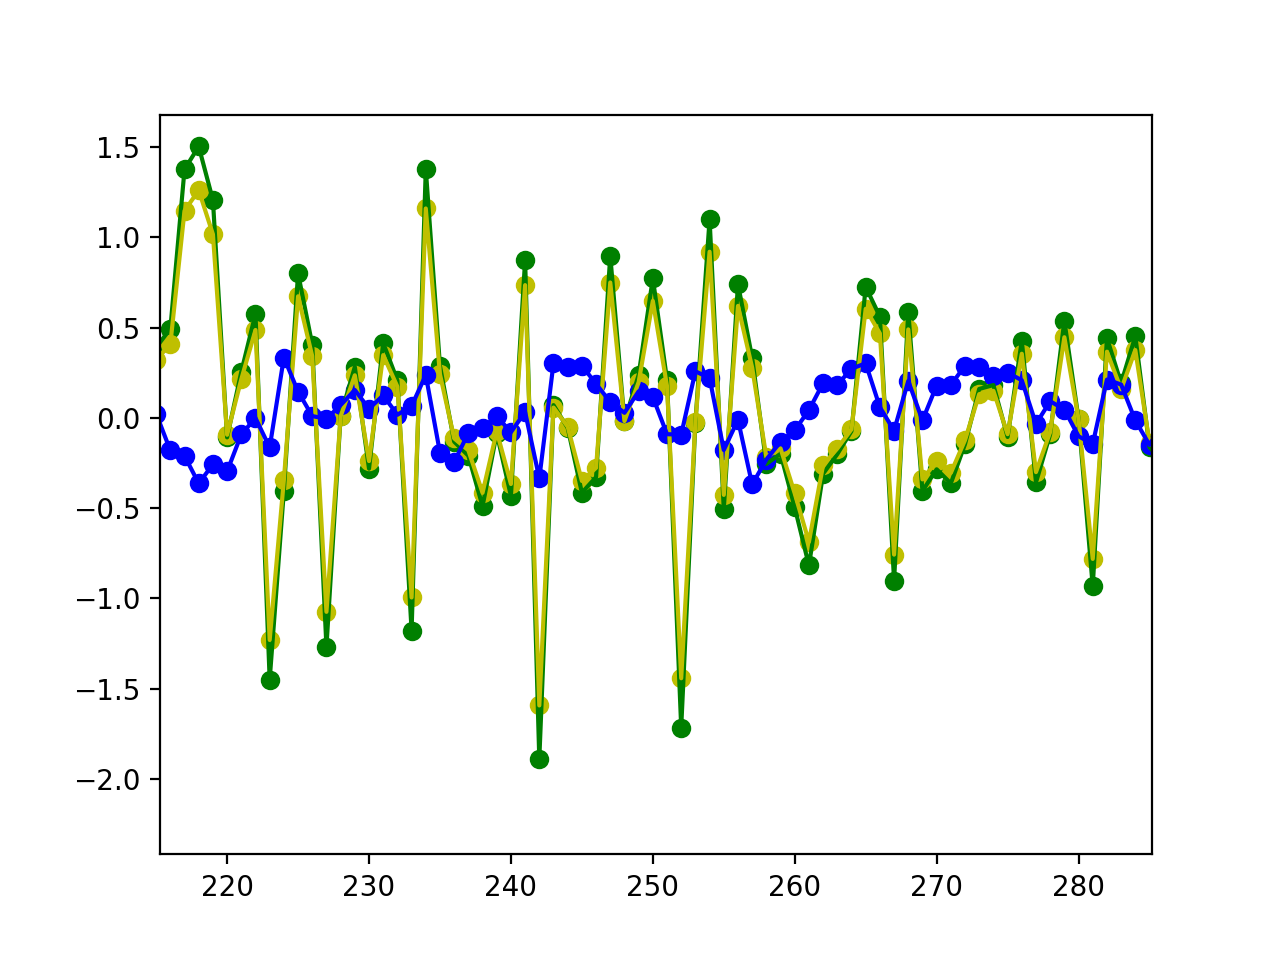

In [65]:
fig, ax = plt.subplots(1)
ax0 = ax
# ax1 = ax[1]
starting_prevday_index = totalIndexes - len(color_df)

ax0.scatter(color_df.iloc[:,0], color_df[[targetMax]], color='g')
ax0.plot(color_df.iloc[:,0], color_df[[targetMax]], color='g')

# plot the difference between the next closing price and the current closing price
price_variation_df = dataset.test_df.shift(-1)[[CryptoDataset.CLOSING_PRICE]] - dataset.test_df[[CryptoDataset.CLOSING_PRICE]]
price_variation_df = price_variation_df[SEQUENCE_SIZE-1:]
ax0.scatter(color_df.iloc[:,0], price_variation_df[[CryptoDataset.CLOSING_PRICE]] * 10000, color='y')
ax0.plot(color_df.iloc[:,0], price_variation_df[[CryptoDataset.CLOSING_PRICE]] * 10000, color='y')

# plot the prediction logarithm
ax0.scatter(color_df.iloc[:,0], color_df[[predictedMax]], color='b')
ax0.plot(color_df.iloc[:,0], color_df[[predictedMax]], color='b')

fig.show()

# Conclusion

We should constantly predict for current hour (using prev data apart from current data)  
and for the next hour and compare if the future prediction is higher / lower from the current  
(maybe also check if the difference is high/low)